# Fitting Holograms

This notebook shows how to upload a data image of a hologram into a Feature object and fit to Lorenz Mie theory.

In [1]:
%matplotlib inline

In [2]:
from pylorenzmie.analysis.Feature import Feature
from pylorenzmie.theory import coordinates
import cv2
import matplotlib.pyplot as plt
from pylorenzmie.theory import LMHologram, coordinates
import numpy as np

INFO:pylorenzmie.fitting:No module named 'pylorenzmie.fitting.cython.cminimizers'
INFO:pylorenzmie.theory:Could not import CUDA GPU pipeline. No module named 'cupy'


First, instantiate the feature object and the instrument configuration. We use $n_m = 1.340$ for particles immersed in water, and $\lambda = 0.447$ for blue laser light. The Boltzmann instrument uses a magnification of $0.048$ while the xSight uses $0.120$.

In [4]:
a = Feature(model=LMHologram())

# Instrument configuration
ins = a.model.instrument
ins.wavelength = 0.447
ins.magnification = 0.048
ins.n_m = 1.34

Then we upload the image of the hologram we wish to fit. This is done with openCV. We assign the data attribute of the Feature object to the image variable.

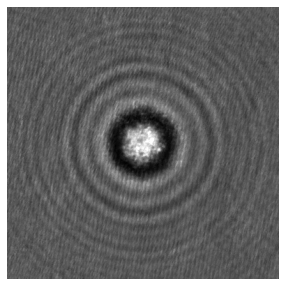

In [5]:
# Read example image
img = cv2.imread('../tutorials/crop.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img / np.mean(img)
shape = img.shape
a.model.coordinates = coordinates(shape, dtype=np.float32)
a.data = img

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img, cmap='gray')
ax.axis('off')
plt.show()

In order to fit, we must first give an initial guess for the parameters of the sphere: The radius $a_p$, refractive index $n_p$, and three-dimensional position $\mathbf{r_p}$.

In this example, we know the true values for this hologram, so we add random noise to these parameters to give the fitter a challenge.

Initial guess:
FastSphere(a_p=1.3128072571722804, n_p=1.392608409149781, k_p=0.0, r_p=[194.26285083 195.75147915 309.21878099])


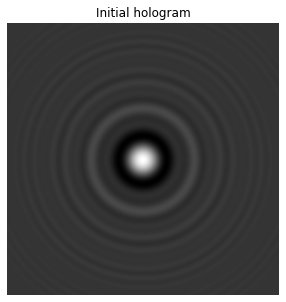

In [6]:
# Initial estimates for particle properties
p = a.model.particle
p.r_p = [shape[0]//2, shape[1]//2, 330.]
p.a_p = 1.1
p.n_p = 1.4
# add errors to parameters
p.r_p += np.random.normal(0., 1, 3)
p.z_p += np.random.normal(0., 30, 1)
p.a_p += np.random.normal(0., 0.1, 1)
p.n_p += np.random.normal(0., 0.04, 1)
print("Initial guess:\n{}".format(p))

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(a.model.hologram().reshape(shape), cmap='gray')
ax.axis('off')
ax.set_title('Initial hologram')
plt.show()

Before fitting, we adjust the settings for the optimizer. Fitting to every pixel in this $390\times 390$px image is time-costly and does not improve accuracy significantly. The optimizer contains a mask, which tells it which pixels to fit on. In this case, we tell the optimizer to only fit to $10 \%$ of the pixels in the image. The distribution "fast" simply chooses these pixels at random.

In [8]:
a.model.hologram()
a.optimizer.mask.settings['distribution'] = 'fast'
a.optimizer.mask.settings['percentpix'] = .1

# ... and now fit
a.model.coordinates = coordinates(shape, dtype=np.float32)
result = a.optimize(method='lm', verbose=False)
print(result)


fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(np.hstack([a.data, a.model.hologram().reshape(shape),a.residuals()+1]), cmap='gray')
ax.axis('off')
ax.set_title('Data, Hologram, Residuals')
plt.show()

Finally, we can fit the image to Lorenz Mie theory to find its best-fit parameters in the effective sphere model. The method name "lm" refers to Levenberg-Marquardt, and is essentially a pixel-by-pixel least-squares fit. 

When we obtain our result, we can print it to get the fitted parameters as well as some information about the fitting process. "redchi" or Reduced $\chi^2$ is a measure of how closely the fitted hologram matches with the original image. This can also be examined visually by looking at the residuals (rightmost plot).

"nfev" stands for "number of function evaluations" and tells how many iterations of the calculation were needed to obtain the answer.

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 4.335833088203413
nfev: 13
x_p: 193.97545 (init: 193.66528)
y_p: 194.56537 (init: 194.80571)
z_p: 370.08636 (init: 368.98203)
a_p: 1.11429 (init: 1.10030)
n_p: 1.41065 (init: 1.41240)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.04800 (init: 0.04800) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)



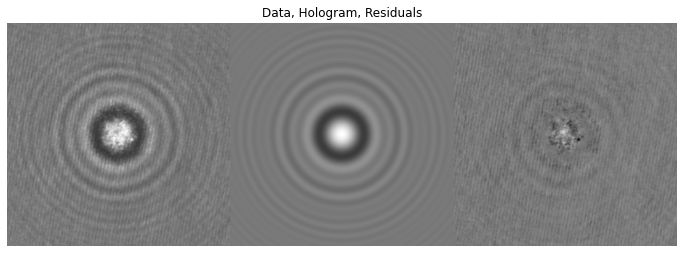

In [9]:
result = a.optimize(method='lm', verbose=False)
print(result)


fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(np.hstack([a.data, a.model.hologram().reshape(shape),a.residuals()+1]), cmap='gray')
ax.axis('off')
ax.set_title('Data, Hologram, Residuals')
plt.show()